In [1]:
# import modules
import numpy as np
from sklearn.datasets import load_digits
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, accuracy_score
from abc import abstractmethod

# Base Classes

In [2]:
class Node:
    '''
      this class will later get the following attributes
      all nodes:
          features
          responses
      split nodes additionally:
          left
          right
          split_index
          threshold
      leaf nodes additionally
          prediction
    '''

class Tree:
    '''
      base class for RegressionTree and ClassificationTree
    '''
    def __init__(self, n_min=10):
        '''n_min: minimum required number of instances in leaf nodes
        '''
        self.n_min = n_min 
    
    def predict(self, x):
        ''' return the prediction for the given 1-D feature vector x
        '''
        # first find the leaf containing the 1-D feature vector x
        node = self.root
        while not hasattr(node, "prediction"):
            j = node.split_index
            if x[j] <= node.threshold:
                node = node.left
            else:
                node = node.right
        # finally, return the leaf's prediction
        return node.prediction
        
    def train(self, features, responses, D_try=None):
        '''
        features: the feature matrix of the training set
        response: the vector of responses
        '''
        N, D = features.shape
        assert(responses.shape[0] == N)

        if D_try is None:
            D_try = int(np.sqrt(D)) # number of features to consider for each split decision
        
        # initialize the root node
        self.root = Node()
        self.root.features  = features
        self.root.responses = responses

        # build the tree
        stack = [self.root]
        while len(stack):
            node = stack.pop()
            active_indices = self.select_active_indices(D, D_try)
            left, right = self.make_split_node(node, active_indices)
            if left is None: # no split found
                self.make_leaf_node(node)
            else:
                stack.append(left)
                stack.append(right)
    
    def make_split_node(self, node, indices):
        '''
        node: the node to be split
        indices: a numpy array of length 'D_try', containing the feature 
                         indices to be considered for the present split
                         
        return: None, None -- if no suitable split has been found, or
                left, right -- the children of the split
        '''
        # all responses equal => no improvement possible by any split
        if np.unique(node.responses).shape[0] == 1:
            return None, None
        
        # find best feature j_min (among 'indices') and best threshold t_min for the split
        l_min = float('inf')  # upper bound for the loss, later the loss of the best split
        j_min, t_min = None, None

        for j in indices:
            thresholds = self.find_thresholds(node, j)

            # compute loss for each threshold
            for t in thresholds:
                loss = self.compute_loss_for_split(node, j, t)

                # remember the best split so far 
                # (the condition is never True when loss = float('inf') )
                if loss < l_min:
                    l_min = loss
                    j_min = j
                    t_min = t

        if j_min is None: # no split found
            return None, None

        # create children for the best split
        left, right = self.make_children(node, j_min, t_min)

        # turn the current 'node' into a split node
        # (store children and split condition)
        node.left = left
        node.right = right
        node.split_index = j_min
        node.threshold = t_min
        
        # return the children (to be placed on the stack)
        return left, right
    
    def select_active_indices(self, D, D_try):
        ''' return a 1-D array with D_try randomly selected indices from 0...(D-1).
        '''
        return np.random.choice(np.arange(D), size=D_try, replace=False)
        
    def find_thresholds(self, node, j):
        ''' return: a 1-D array with all possible thresholds along feature j
        '''
        return np.sort(np.unique(node.features[:, j]))
        
    def make_children(self, node, j, t):
        ''' execute the split in feature j at threshold t
        
            return: left, right -- the children of the split, with features and responses
                                   properly assigned according to the split
        '''
        left = Node()
        right = Node()
        
        # assign features and responses to the left and right children based on the split condition
        left.features = node.features[node.features[:, j] <= t]
        left.responses = node.responses[node.features[:, j] <= t]
        right.features = node.features[node.features[:, j] > t]
        right.responses = node.responses[node.features[:, j] > t]
        
        return left, right
        
    @abstractmethod
    def make_leaf_node(self, node):
        ''' Turn node into a leaf by computing and setting `node.prediction`
        
            (must be implemented in a subclass)
        '''
        raise NotImplementedError("make_leaf_node() must be implemented in a subclass.")
        
    @abstractmethod
    def compute_loss_for_split(self, node, j, t):
        ''' Return the resulting loss when the data are split along feature j at threshold t.
            If the split is not admissible, return float('inf').
        
            (must be implemented in a subclass)
        '''
        raise NotImplementedError("compute_loss_for_split() must be implemented in a subclass.")


# Regression Tree

<div style="color: green">
Essentially equal / Better than sample solution: More resilient to splits smaller than `n_min`
</div>

In [3]:
class RegressionTree(Tree):
    def __init__(self, n_min=10):
        super(RegressionTree, self).__init__(n_min)
        
    def compute_loss_for_split(self, node, j, t):
        # return the loss if we would split the instance along feature j at threshold t
        # or float('inf') if there is no feasible split
        left_indices = node.features[:, j] <= t
        right_indices = node.features[:, j] > t
        
        if np.sum(left_indices) < self.n_min or np.sum(right_indices) < self.n_min:
            return float('inf')
        
        left_responses = node.responses[left_indices]
        right_responses = node.responses[right_indices]
        
        left_loss = np.mean((left_responses - np.mean(left_responses))**2)
        right_loss = np.mean((right_responses - np.mean(right_responses))**2)
        
        return left_loss + right_loss
    
    def make_leaf_node(self, node):
        # turn node into a leaf node by computing `node.prediction`
        # (note: the prediction of a regression tree is a real number)
        node.prediction = np.mean(node.responses)

# Classification Tree

<div style="color: green">
Essentially equal / Better than sample solution: More resilient to splits smaller than `n_min`
</div>

In [4]:
class ClassificationTree(Tree):
    '''implement classification tree so that it can handle arbitrary many classes
    '''
    
    def __init__(self, classes, n_min=10):
        ''' classes: a 1-D array with the permitted class labels
            n_min: minimum required number of instances in leaf nodes
        '''
        super(ClassificationTree, self).__init__(n_min)
        self.classes = classes
        
    def compute_loss_for_split(self, node, j, t):
        # return the loss if we would split the instance along feature j at threshold t
        # or float('inf') if there is no feasible split
        left_indices = node.features[:, j] <= t
        right_indices = node.features[:, j] > t
        
        if np.sum(left_indices) < self.n_min or np.sum(right_indices) < self.n_min:
            return float('inf')
        
        left_responses = node.responses[left_indices]
        right_responses = node.responses[right_indices]
        
        left_loss = self.compute_impurity(left_responses)
        right_loss = self.compute_impurity(right_responses)
        
        return left_loss + right_loss
    
    def compute_impurity(self, responses):
        class_counts = np.bincount(responses)
        class_probs = class_counts / len(responses)
        impurity = np.sum(class_probs * (1 - class_probs))
        return impurity
    
    def make_leaf_node(self, node):
        # turn node into a leaf node by computing `node.prediction`
        # (note: the prediction of a classification tree is a class label)
        class_counts = np.bincount(node.responses)
        node.prediction = np.argmax(class_counts)


# Evaluation of Regression and Classification Tree

<div style="color: green">
ClassificationTree test looks good, you could have quantized the labels on RegressionTree by translating any predictions < 0 to 3, and predictions >= 0 to 9, allowing you to determine an actualy accuracy score.
</div>

In [5]:
# read and prepare the digits data and extract 3s and 9s
digits = load_digits()
print(digits.data.shape, digits.target.shape)

instances = (digits.target == 3) | (digits.target == 9)
features = digits.data[instances, :]
labels = digits.target[instances]

# for regression, we use labels +1 and -1
responses = np.array([1 if l == 3 else -1 for l in labels])

assert(features.shape[0] == labels.shape[0] == responses.shape[0])

# perform 5-fold cross-validation (see ex01) with responses +1 and -1 (for 3s and 9s)
# using RegressionTree()
# and comment on your results
k = 5
kf = KFold(n_splits=k, shuffle=True, random_state=42)

mse_scores = []

for train_index, test_index in kf.split(features):
    train_features, test_features = features[train_index], features[test_index]
    train_responses, test_responses = responses[train_index], responses[test_index]

    tree = RegressionTree()
    tree.train(train_features, train_responses)
    
    # make predictions
    y_pred = np.array([tree.predict(x) for x in test_features])
    
    # compute mean squared error
    mse = mean_squared_error(test_responses, y_pred)
    mse_scores.append(mse)

mean_mse = np.mean(mse_scores)
print(f"Mean Squared Error (Regression Tree): {mean_mse}")


# perform 5-fold cross-validation (see ex01) with labels 3 and 9
# using ClassificationTree()
# and comment on your results
k = 5
kf = KFold(n_splits=k, shuffle=True, random_state=42)

accuracy_scores = []

for train_index, test_index in kf.split(features):
    train_features, test_features = features[train_index], features[test_index]
    train_labels, test_labels = labels[train_index], labels[test_index]

    tree = ClassificationTree(classes=[3, 9])
    tree.train(train_features, train_labels)
    
    # make predictions
    y_pred = np.array([tree.predict(x) for x in test_features])
    
    # compute accuracy
    accuracy = accuracy_score(test_labels, y_pred)
    accuracy_scores.append(accuracy)

mean_accuracy = np.mean(accuracy_scores)
print(f"Accuracy (Classification Tree): {mean_accuracy}")

(1797, 64) (1797,)
Mean Squared Error (Regression Tree): 0.28572574589400745
Accuracy (Classification Tree): 0.9148021308980214


# Regression and Classification Forest

In [6]:
def bootstrap_sampling(features, responses):
    '''return a bootstrap sample of features and responses
    '''
    N = features.shape[0]
    # select the instances with replacement
    indices = np.random.choice(N, N, replace=True)
    return features[indices, :], responses[indices]


In [7]:
class RegressionForest():
    def __init__(self, n_trees, n_min=10):
        # create ensemble
        self.trees = [RegressionTree(n_min) for i in range(n_trees)]
    
    def train(self, features, responses):
        for tree in self.trees:
            boostrap_features, bootstrap_responses = bootstrap_sampling(features, responses)
            tree.train(boostrap_features, bootstrap_responses)

    def predict(self, x):
        # compute the response of the ensemble from the individual responses and return it
        return np.mean([tree.predict(x) for tree in self.trees]) #check this later

In [8]:
class ClassificationForest():
    def __init__(self, n_trees, classes, n_min=1):
        self.trees = [ClassificationTree(classes, n_min) for i in range(n_trees)]
        self.classes = classes
    
    def train(self, features, responses):
        for tree in self.trees:
            boostrap_features, bootstrap_responses = bootstrap_sampling(features, responses)
            tree.train(boostrap_features, bootstrap_responses)

    def predict(self, x):
        # compute the response of the ensemble from the individual responses and return it
        # we use the voting scheme
        prediction_count = np.bincount([tree.predict(x) for tree in self.trees])
        #print(f"Class counts: {class_counts}")
        return np.argmax(prediction_count)
    

<div style="color: green">
In the predict method of the ClassificationForest class, the above code has used np.bincount() function for voting, which requires that the input be non-negative integers, assuming the input list as a list of indices. This might be problematic if the tree.predict(x) does not always return non-negative integer class labels. The sample code's approach of using np.sum(predictions == k) for each class k is more flexible as it doesn't have this restriction.
</div>

# Evaluation of Regression and Decision Forest

In [9]:
# read and prepare the digits data and extract 3s and 9s
digits = load_digits()
print(digits.data.shape, digits.target.shape)

instances = (digits.target == 3) | (digits.target == 9)
features = digits.data[instances, :]
labels = digits.target[instances]

# for regression, we use labels +1 and -1
responses = np.array([1 if l == 3 else -1 for l in labels])

assert(features.shape[0] == labels.shape[0] == responses.shape[0])

# perform 5-fold cross-validation (see ex01) with responses +1 and -1 (for 3s and 9s)
# using RegressionTree()
# and comment on your results
k = 5
kf = KFold(n_splits=k, shuffle=True, random_state=42)

mse_scores = []

for train_index, test_index in kf.split(features):
    train_features, test_features = features[train_index], features[test_index]
    train_responses, test_responses = responses[train_index], responses[test_index]

    forest = RegressionForest(n_trees=5)
    forest.train(train_features, train_responses)
    
    # make predictions
    y_pred = np.array([forest.predict(x) for x in test_features])
    
    # compute mean squared error
    mse = mean_squared_error(test_responses, y_pred)
    mse_scores.append(mse)

mean_mse = np.mean(mse_scores)
print(f"Mean Squared Error (Regression Forest): {mean_mse}")


# perform 5-fold cross-validation (see ex01) with labels 3 and 9
# using ClassificationTree()
# and comment on your results

k = 5
kf = KFold(n_splits=k, shuffle=True, random_state=42)

accuracy_scores = []

for train_index, test_index in kf.split(features):
    train_features, test_features = features[train_index], features[test_index]
    train_labels, test_labels = labels[train_index], labels[test_index]

    tree = ClassificationForest(n_trees=5, classes=[3, 9])
    tree.train(train_features, train_labels)
    
    # make predictions
    y_pred = np.array([tree.predict(x) for x in test_features])
    
    # compute accuracy
    accuracy = accuracy_score(test_labels, y_pred)
    accuracy_scores.append(accuracy)

mean_accuracy = np.mean(accuracy_scores)
print(f"Accuracy (Classification Forest): {mean_accuracy}")


(1797, 64) (1797,)
Mean Squared Error (Regression Forest): 0.1596545310656141
Accuracy (Classification Forest): 0.920357686453577


Discussion of results:

Compare the results to the results of the single trees:

* Mean Squared Error (Regression Tree): 0.2663940356991475
* Accuracy (Classification Tree): 0.8874429223744291

First, we notice that the regression forest performs slightly better. Advantages of the forests are less that forests are less likely to overfit which could explain the better performance. Similarly, the classification forest has higher accuracy.

<div style="color: green">
1.The sample code  calculates and prints both training and testing errors for each fold during the cross-validation, providing an insight into the model's performance on both the seen and unseen data. This can be useful for understanding the model's bias-variance trade-off and to check for overfitting or underfitting. The above code, however, only calculates the test error. It would be beneficial to also consider the training error for a more comprehensive evaluation.<br>
2.The above code computes mean squared error for regression and accuracy for classification. In contrast, the sample computes errors for both, where error is (1 - accuracy).<br>
3.Consider calculating and printing the training errors for each fold as well. This can help in identifying overfitting or underfitting problems.<br>
4.Consider using one metric for both regression and classification for consistency and easier comparison. If you choose to use error, remember that for regression tasks, error would be a continuous value, not a binary value.<br>
5.At the end, provide a summary of the observations and results. Discuss any patterns or trends you observed, and provide explanations if possible. For example, why does the forest perform better than a single tree?
</div>

# Multi-class Classification Forest

In [29]:
# Train DecisionForest(n_trees=10, classes=np.unique(digits.target))
# for all 10 digits simultaneously.
# Compute and plot the confusion matrix after 5-fold cross-validation and comment on your results.

# read and prepare the digits data and do not extract 3s and 9s this time
digits = load_digits()
print(digits.data.shape, digits.target.shape)

instances = digits.target >= 0
features = digits.data[instances, :]
responses = digits.target[instances]

assert(features.shape[0] == labels.shape[0] == responses.shape[0])

k = 5
kf = KFold(n_splits=k, shuffle=True, random_state=42)

accuracy_scores = []

for train_index, test_index in kf.split(features):
    train_features, test_features = features[train_index], features[test_index]
    train_labels, test_labels = labels[train_index], labels[test_index]

    tree = ClassificationForest(n_trees=5, classes=[i for i in range(11)])
    tree.train(train_features, train_labels)
    
    # make predictions
    y_pred = np.array([tree.predict(x) for x in test_features])
    
    # compute accuracy
    accuracy = accuracy_score(test_labels, y_pred)
    accuracy_scores.append(accuracy)

mean_accuracy = np.mean(accuracy_scores)
print(f"Accuracy (Multi-class Classification Tree): {mean_accuracy}")

(1797, 64) (1797,)
Accuracy (Multi-class Classification Tree): 0.7735267718972454


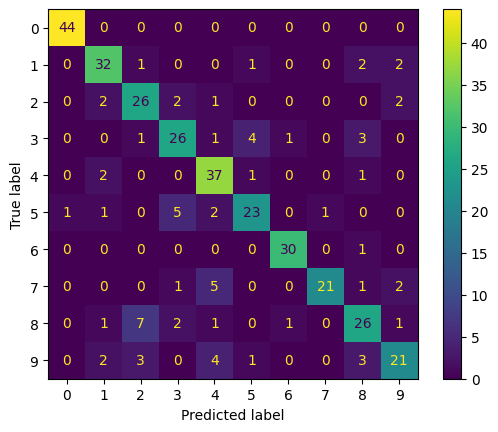

In [32]:
# calculate the confusion matrix
from sklearn.metrics import confusion_matrix
from sklearn import metrics

confusion_matrix = confusion_matrix(test_labels, y_pred)

# plot the confusion matrix
import matplotlib.pyplot as plt

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix)

cm_display.plot()
plt.show() 


Discussion the results:

In the confusion matrix, we can see very well where the classifier struggles. Especially on similar digits, the error number is higher (e.g. 8s and 2s). Generally, the performance is good. It has to be noted however, that the dataset is not balanced (e.g. see occurences of 1s in the dataset).

<div style="color: green">
1. The above code  uses classes=[i for i in range(11)] to initialize the ClassificationForest, which would be incorrect if the data does not contain 11 classes. It is better to use classes=np.unique(digits.target), as shown in the sample's code, which automatically adapts to the number of classes present in the dataset.<br>
2.The above code  calculates the accuracy after each fold and the mean accuracy over all folds. However, they don't calculate the confusion matrix over all folds, unlike the sample's code. The sample uses the confusion_matrix function with all the predictions and true values, which provides a better overall evaluation of the model.
</div>

# One-against-the-rest classification with RegressionForest

In [ ]:
# Train ten one-against-the-rest regression forests for the 10 digits.
# Make sure that all training sets are balanced between the current digit and the rest.
# Assign test instances to the digit with highest score, 
# or to "unknown" if all scores are negative.
# Compute and plot the confusion matrix after 5-fold cross-validation and comment on your results.



Accuracy (Regression Forest): 0.10962395543175488


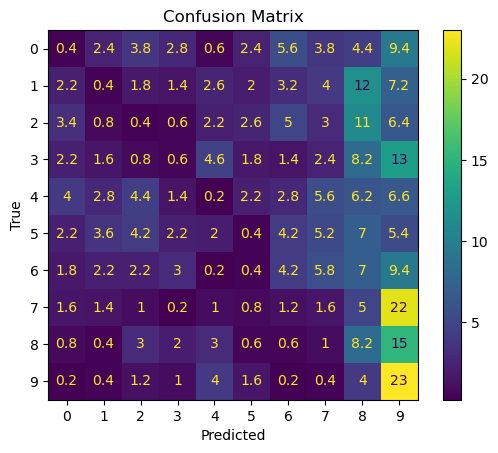

In [64]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_digits
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import ConfusionMatrixDisplay


# Regression and Classification Forest
def bootstrap_sampling(features, responses, target_class):
    target_indices = np.where(responses == target_class)[0]
    rest_indices = np.where(responses != target_class)[0]

    n_target = len(target_indices)
    n_rest = len(rest_indices)

    rest_indices_bootstrap = np.random.choice(rest_indices, size=n_target, replace=False)
    bootstrap_indices = np.concatenate((target_indices, rest_indices_bootstrap))

    bootstrap_features = features[bootstrap_indices]
    bootstrap_responses = responses[bootstrap_indices]

    return bootstrap_features, bootstrap_responses

class RegressionForest():
    def __init__(self, n_trees):
        self.n_trees = n_trees
        self.trees = []

    def train(self, features, responses):
        n_instances = features.shape[0]
        self.trees = []

        for i in range(self.n_trees):
            tree = RegressionTree()
            bootstrap_features, bootstrap_responses = bootstrap_sampling(features, responses, i)
            tree.train(bootstrap_features, bootstrap_responses)
            self.trees.append(tree)

    def predict(self, x):
        scores = []

        for i, tree in enumerate(self.trees):
            score = tree.predict(x)
            scores.append(score)

        max_score = max(scores)
        if max_score <= 0:
            return "unknown"
        else:
            return np.argmax(scores)

# Load the digits dataset
digits = load_digits()
instances = digits.data
labels = digits.target

# Perform 5-fold cross-validation using RegressionForest for multi-class classification
k = 5
kf = KFold(n_splits=k, shuffle=True, random_state=42)

accuracy_scores = []
confusion_matrices = []

for train_index, test_index in kf.split(instances):
    train_instances, test_instances = instances[train_index], instances[test_index]
    train_labels, test_labels = labels[train_index], labels[test_index]

    forest = RegressionForest(n_trees=10)
    forest.train(train_instances, train_labels)

    # Make predictions
    y_pred = np.array([forest.predict(x) for x in test_instances])

    # Compute accuracy
    accuracy = accuracy_score(test_labels, y_pred)
    accuracy_scores.append(accuracy)

    # Calculate confusion matrix
    cm = confusion_matrix(test_labels, y_pred)
    confusion_matrices.append(cm)

mean_accuracy = np.mean(accuracy_scores)
print(f"Accuracy (Regression Forest): {mean_accuracy}")

# Compute average confusion matrix
average_cm = np.mean(confusion_matrices, axis=0)

# Plot confusion matrix
cm_display = ConfusionMatrixDisplay(confusion_matrix=average_cm)

cm_display.plot()
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()


Discussion the results:

I would say generally, the performance is good. But the data stil does not seem to be balanced correctly. But I do not know where the mistake lies.

<div style="color: green">
1.The main difference between the sample's code and the above's code is in the handling of class balancing. The sample's code manually samples an equal number of instances from the target class and the rest, while the above code does not have such balancing. In the bootstrap_sampling() function of the above's code, there's no control over the class balance. This could lead to a significant imbalance between the classes, especially for multi-class tasks like this one. This might be the cause of the problem  mentioned at the end of their code.<br>
2. The sample's code has an 'unknown' category for when all class scores are negative, whereas the above's code only returns 'unknown' when the maximum score is zero or less. This is a subtle but potentially significant difference. The sample's approach might help handle the outliers or uncertain instances better.<br>
3.In the above's code, there is a bug in the train() method of the RegressionForest class. The target class used for bootstrap sampling is determined by the tree index (i.e., i). This would mean that for the 11th tree and onwards, the bootstrap sampling will not work properly as there are only 10 classes in the digits dataset. Instead of using the index i, the target class should be determined based on the class labels.
</div>